Importing libraries

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import sys
import os

# Go up one level to the repo root
sys.path.append(os.path.abspath(".."))
# Import preprocessing functions
from src.preprocessing import load_images_and_labels, encode_labels, split_data, create_datagen

# Optional: set random seed
import tensorflow as tf
import random
import os

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [6]:
# Load images
X, y = load_images_and_labels(data_path=r"C:\Users\USER\TB-MLPipeline\data\train")
y_encoded, le = encode_labels(y)

# Split into train/test
X_train, X_test, y_train, y_test = split_data(X, y_encoded)

# One-hot encode labels for CNN
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train_cat.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test_cat.shape)


Shapes:
X_train: (5088, 224, 224, 3)
y_train: (5088, 4)
X_test: (1273, 224, 224, 3)
y_test: (1273, 4)


PNEUMONIA        3883
NORMAL           1349
TURBERCULOSIS     659
COVID19           470
Name: count, dtype: int64


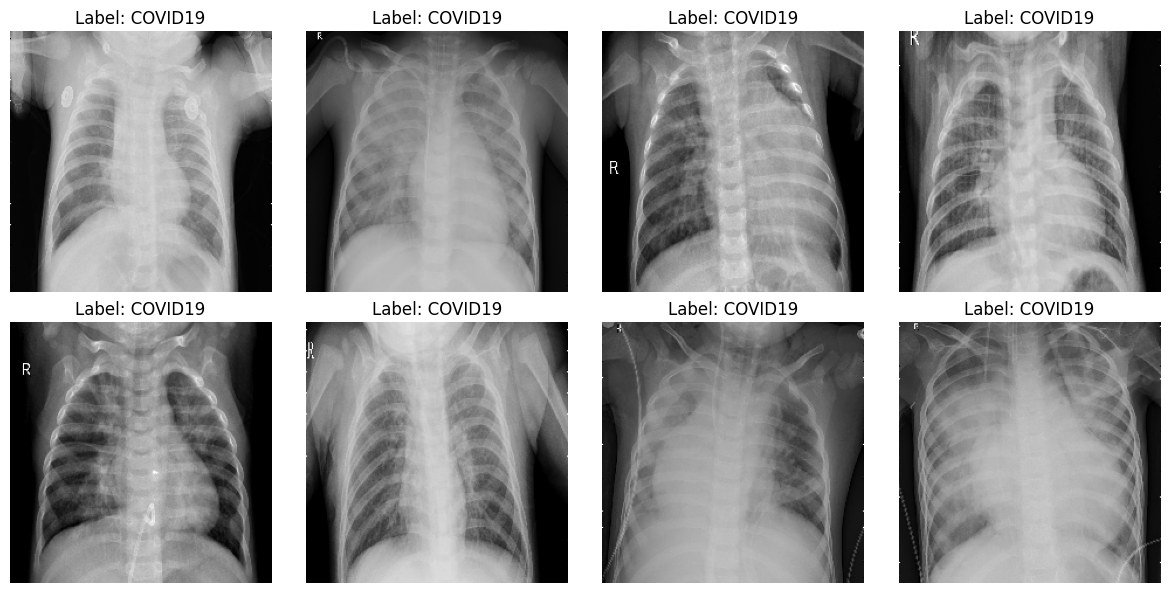

In [8]:
# Show number of images per class
import pandas as pd

class_counts = pd.Series(y).value_counts()
print(class_counts)

# Show sample images
fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


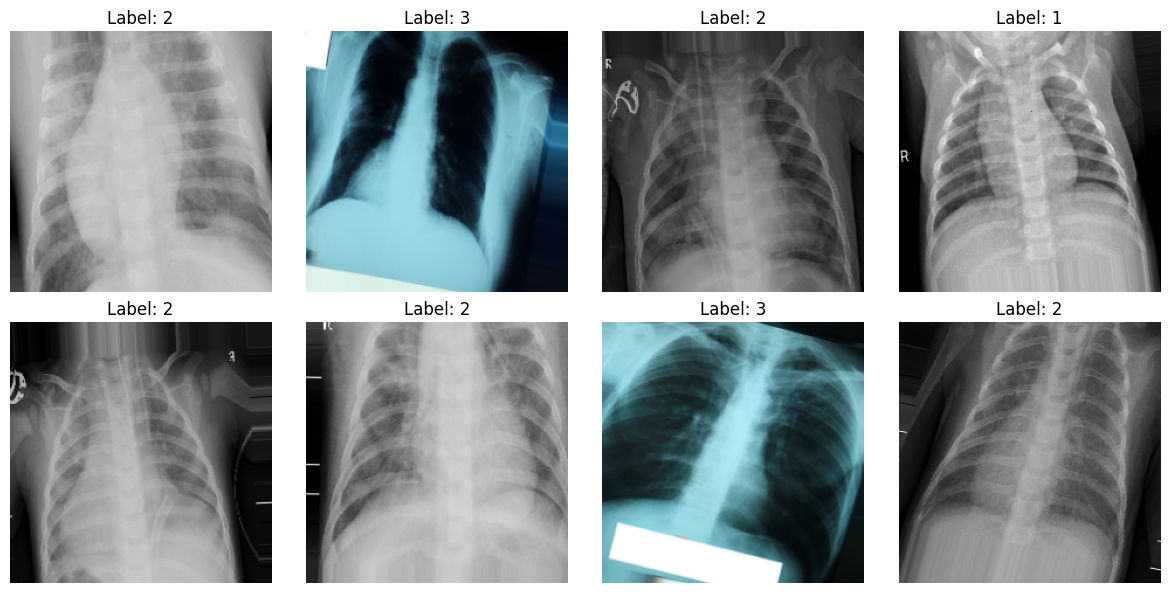

In [9]:
# Create augmentation generator
datagen = create_datagen()
datagen.fit(X_train)

# Example: show one augmented batch
for X_batch, y_batch in datagen.flow(X_train, y_train_cat, batch_size=8):
    fig, axes = plt.subplots(2,4, figsize=(12,6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(X_batch[i])
        ax.set_title(f"Label: {np.argmax(y_batch[i])}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\USER\TB-MLPipeline\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_test, y_test_cat),
    epochs=10
)


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.7524 - loss: 0.6552 - val_accuracy: 0.7793 - val_loss: 0.5128
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8351 - loss: 0.4335 - val_accuracy: 0.8987 - val_loss: 0.2814
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8585 - loss: 0.3949 - val_accuracy: 0.9112 - val_loss: 0.2701
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8734 - loss: 0.3459 - val_accuracy: 0.9317 - val_loss: 0.2095
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8772 - loss: 0.3426 - val_accuracy: 0.9379 - val_loss: 0.2085
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8866 - loss: 0.3221 - val_accuracy: 0.9364 - val_loss: 0.1895
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9017 - loss: 0.2738 - val_accuracy: 0.9379 - val_loss: 0.1901
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9019 - loss: 0.2748 - val_accu

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step
Confusion Matrix:
 [[ 84   2   3   5]
 [  3 247  20   0]
 [  7  20 750   0]
 [  4   1   0 127]]
               precision    recall  f1-score   support

      COVID19       0.86      0.89      0.88        94
       NORMAL       0.91      0.91      0.91       270
    PNEUMONIA       0.97      0.97      0.97       777
TURBERCULOSIS       0.96      0.96      0.96       132

     accuracy                           0.95      1273
    macro avg       0.93      0.93      0.93      1273
 weighted avg       0.95      0.95      0.95      1273



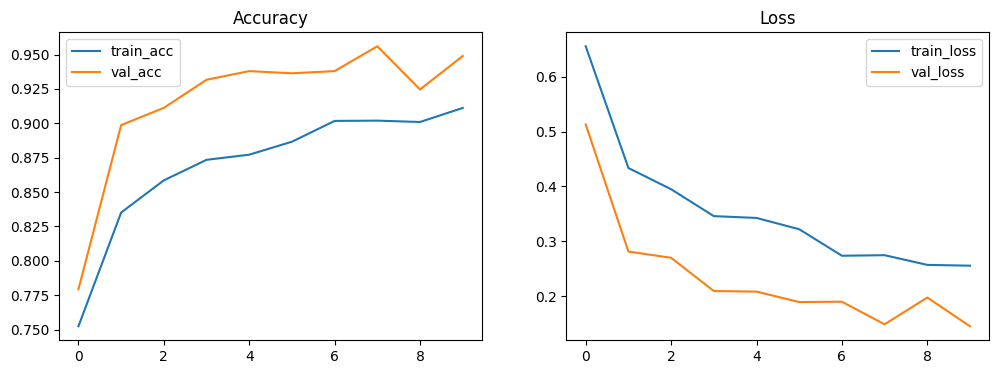

In [12]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred_classes, target_names=le.classes_)
print(report)

# Plot accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()


In [13]:
model.save("models/cnn_model_v1.h5")
print("Model saved!")


Model saved!
